In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import PyHyperScattering
import os
import shutil
import psutil
import pickle
import imageio
from PIL import Image
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import scipy.ndimage as nd
from matplotlib import font_manager
from matplotlib.colors import LogNorm
from matplotlib.colorbar import Colorbar as colorbar
from IPython.display import clear_output

Imports failed.  Are you running on a machine with proper libraries for databroker, tiled, etc.?


In [70]:
# variables to store directories, enables easy switching between systems
font_dirs = ['C:/Users/Phong/Box/Research/Mixed Conduction Project/RSOXS Projects/Shared RSoXS Folder/Fonts/']

base_data_dirs = [r'C:\Users\Phong\Desktop\CyRSoXS\v4_sims\sims\Reduced_F4TCNQ\C_K_Edge_Reduced_F4TCNQ\Phong_Pickled_Morphologies_v4_C_Perp_F4TCNQ_Fibril\100-400nm\Average_Oriented\1024x1024x512nm_pitch2nm_rad15nm_std3nm_1250fib_100-400nm']

base_save_dir = base_data_dirs[0]

In [71]:
font_files = font_manager.findSystemFonts(fontpaths = font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# font_names = [f.name for f in font_manager.fontManager.ttflist]
# print(font_names)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

cmap = mpl.cm.viridis
cmap.set_bad((68/255, 1/255, 84/255), 1)

In [72]:
def get_immediate_subdirectories(a_dir):
    
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    
    return r'${} \times 10^{{{}}}$'.format(a, b)

def fmt_AR(x, pos):
    return '{:.2f}'.format(x)

def find_edge(scan):
    if np.min(scan.energy) == 270:
        current_edge = 'C 1s'
    elif np.min(scan.energy) == 385:
        current_edge = 'N 1s'
    elif np.min(scan.energy) == 670:
        current_edge = 'F 1s'
    else:
        current_edge = 'unknown'
        
    return current_edge

def make_output_dir(base_save_dir, tail):
# tail is a string that describes the data file being exported, used as folder prefix    
    # create directories for output files
    save_dir = os.path.join(base_save_dir, f'{tail}_Fibril_C1s')
    os.makedirs(save_dir, exist_ok = True)
    
    return save_dir

def clear_dir(dir):
    for file_name in os.listdir(dir):
        file_path = os.path.join(dir, file_name)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
            
def sample_name_root(scan):
    current_edge = find_edge(scan)
    return f'{current_edge.replace(" ", "")}_{scan.sample_name}'


def setup_plot():
    plt.rcParams.update({"font.size": 18})
    plt.rcParams.update({"axes.linewidth": 2})

    fig, axes = plt.subplots(1, 1, figsize = (3.5, 3.5))

    # Edit the major and minor ticks of the x and y axes
    axes.xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', top = 'on')
    axes.xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', top = 'on')
    axes.yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
    axes.yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')
    
    return [fig, axes]
    
def save_fig(fig, current_energy, save_dir, tail, res):
    if current_energy > 0:
        save_path = os.path.join(save_dir, f'{tail}_Fibril_C1s_{current_energy}eV.png')
        fig.savefig(save_path, dpi=res, bbox_inches='tight', pad_inches = 0.2, transparent=True)
    else:
        save_path = os.path.join(save_dir, f'{tail}_Fibril_C1s.png')
        fig.savefig(save_path, dpi=res, bbox_inches='tight', pad_inches = 0.2, transparent=True)
        
def find_largest_dimensions(images):
    max_width = 0
    max_height = 0
    for img in images:
        width, height = img.size
        max_width = max(max_width, width)
        max_height = max(max_height, height)
    return max_width, max_height

def add_padding(image, target_size):
    width, height = image.size
    new_image = Image.new("RGBA", target_size, (255, 255, 255, 255))
    new_image.paste(image, (0, 0))
    return new_image

def make_gif(input_dir, output_dir, tail):
    image_folder = os.fsencode(input_dir)
    file_names = []

    for file in os.listdir(image_folder):
        file_name = os.fsdecode(file)
        file_names.append(file_name)

    file_names.sort()

    # Make it pause at the end
    for _ in range(10):
        file_names.append(file_names[-1])

    pil_images = [Image.open(os.path.join(input_dir, file_name)) for file_name in file_names]
    max_width, max_height = find_largest_dimensions(pil_images)
    padded_images = [add_padding(img, (max_width, max_height)) for img in pil_images]

    # Convert PIL images back to a format suitable for saving as GIF
    padded_images = [image.convert('P', palette=Image.ADAPTIVE) for image in padded_images]

    padded_images[0].save(os.path.join(output_dir, f'{tail}_Fibril_C1s.gif'),
                           save_all=True,
                           append_images=padded_images[1:],
                           duration=250,  # 250 milliseconds per frame
                           loop=0)  # Loop count (0 for infinite)
    
def generate_ticks(start, end, num_ticks, rounding_order):
    tick_spacing = (end - start) / (num_ticks - 1)
    tick_vals = [start + i * tick_spacing for i in range(num_ticks)]

    # Convert rounding_order to float and check if it's a whole number or a fractional value
    rounding_order_float = float(rounding_order)
    if rounding_order_float.is_integer():
        # For whole number rounding_order, round to the nearest integer
        rounded_tick_vals = [round(val / rounding_order) * rounding_order for val in tick_vals]
    else:
        # For fractional rounding_order, determine the number of decimal places
        decimal_places = abs(int(np.floor(np.log10(rounding_order))))
        rounded_tick_vals = [round(val, decimal_places) for val in tick_vals]

    return rounded_tick_vals

# def generate_ticks(start, end, num_ticks, rounding_order):
#     tick_spacing = (end - start) / (num_ticks - 1)
#     tick_vals = [start + i * tick_spacing for i in range(num_ticks)]
#     rounded_tick_vals = [round(val / rounding_order) * rounding_order for val in tick_vals]
    
#     return rounded_tick_vals

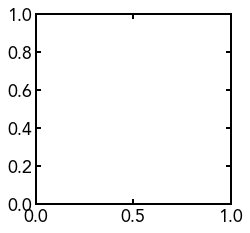

In [73]:
# sacrificial empty plot because the first plot does not properly update params
[fig, axes] = setup_plot()

plt.rcParams.update({"font.size": 18})
plt.rcParams.update({"axes.linewidth": 2})

In [74]:
file_loader = PyHyperScattering.load.cyrsoxsLoader()

scan = file_loader.loadDirectory(base_data_dirs[0],PhysSize = 20)

Finished reading 54 energies. Time required: 0:00:00.411683


In [75]:
integ = PyHyperScattering.integrate.WPIntegrator()

integrated_data = integ.integrateImageStack(scan)

  0%|          | 0/54 [00:00<?, ?it/s]

In [76]:
# variables to append sample ID and AR xarrays
scan_ids = []
sample_names = []
edges = []

ARs = []
AR_scales = []

paras = []
para_scales = []

perps = []
perp_scales = []

circs = []
circ_scales = []

FY_NEXAFSs = []

Iq2s = []
ISIs = []

del scan_ids
del sample_names
del edges

del ARs
del AR_scales

del paras
del para_scales

del perps
del perp_scales

del circs
del circ_scales

del FY_NEXAFSs

del Iq2s
del ISIs

scan_ids = []
sample_names = []
edges = []

ARs = []
AR_scales = []

paras = []
para_scales = []

perps = []
perp_scales = []

circs = []
circ_scales = []

FY_NEXAFSs = []

Iq2s = []
ISIs = []

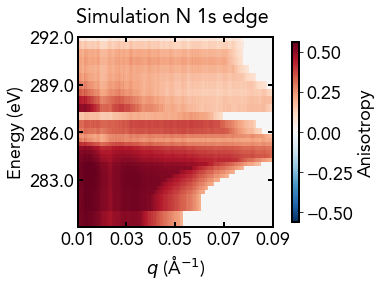

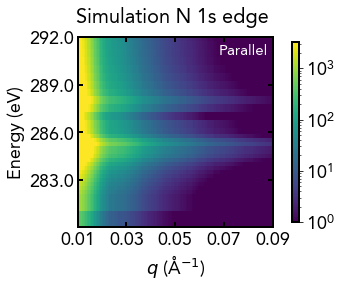

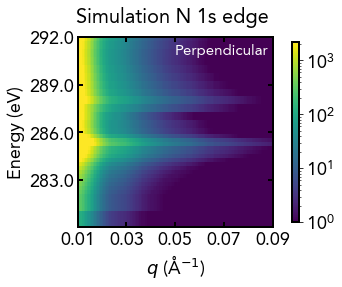

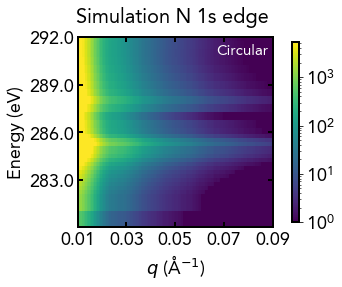

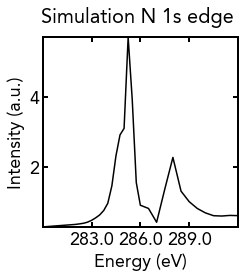

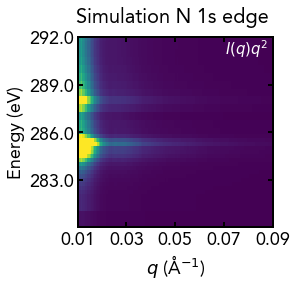

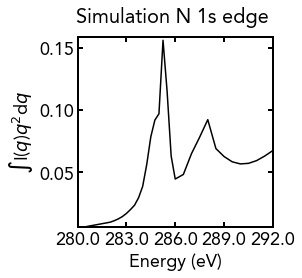

In [79]:
start_en = 280
end_en = 292
en_rounding_order = 0.1
start_q = 0.01
end_q = 0.09
q_rounding_order = 0.01

current_edge = 'N 1s'

# make sure final processing output directory exists
reduced_save_dir = make_output_dir(base_save_dir, '0_reduced')

# Make sure directories exist
just_rel_detImage_save_dir = make_output_dir(base_save_dir, 'just_rel_detImage')
rel_detImage_save_dir = make_output_dir(base_save_dir, 'rel_detImage')
abs_detImage_save_dir = make_output_dir(base_save_dir, 'abs_detImage')
rel_linecuts_save_dir = make_output_dir(base_save_dir, 'rel_linecuts')
abs_linecuts_save_dir = make_output_dir(base_save_dir, 'abs_linecuts')

# Remove old files
clear_dir(rel_detImage_save_dir)
clear_dir(abs_detImage_save_dir)
clear_dir(rel_linecuts_save_dir)
clear_dir(abs_linecuts_save_dir)

clear_dir(reduced_save_dir)

## Make plot of the AR
para = integrated_data.rsoxs.slice_chi(90, chi_width = 45).sel(q = slice(start_q, end_q)) + integrated_data.rsoxs.slice_chi(-90, chi_width = 45).sel(q = slice(start_q, end_q))
perp = integrated_data.rsoxs.slice_chi(0, chi_width = 45).sel(q = slice(start_q, end_q)) + integrated_data.rsoxs.slice_chi(180, chi_width = 45).sel(q = slice(start_q, end_q))

AR = (para - perp)/(para + perp)

AR_scales.append(np.nanmax([abs(np.nanpercentile(AR.sel(energy = slice(start_en, end_en)), 1)), abs(np.nanpercentile(AR.sel(energy = slice(start_en, end_en)), 99))]))

# AR_scales = [0.1]

# log info for mosaic
ARs.append(AR)    

[fig, axes] = setup_plot()

im_cbar = AR.sel(energy = slice(start_en, end_en)).plot(
    x = 'q', y = 'energy',
    ax = axes,
    vmin = -AR_scales[-1],
    vmax = AR_scales[-1],
    cmap = 'RdBu_r',
    add_colorbar = False)

cbar_ax = fig.add_axes([0.975, 0.145, 0.03, 0.715])
cbar = fig.colorbar(im_cbar, cax = cbar_ax)

# plt.setp(cbar.ax.get_yticklabels(), ha = "right")
# cbar.ax.tick_params(pad = 37.5)
cbar.ax.set_ylabel('Anisotropy')

fig.suptitle(f'Simulation {current_edge} edge', fontsize = 20, y = 1, x = 0.5)
axes.set_xlabel('$\it{q}$ (Å$^{-1}$)')
axes.set_ylabel('Energy (eV)')
axes.set_xlim([start_q, end_q])
x_ticks = generate_ticks(start_q, end_q, num_ticks=5, rounding_order=q_rounding_order)
axes.set_xticks(x_ticks)
x_ticks_strs = [str(value) for value in x_ticks]
# x_ticks_strs[0] = ''
# x_ticks_strs[-1] = ''
axes.set_xticklabels(x_ticks_strs)
axes.set_ylim([start_en, end_en])
y_ticks = generate_ticks(start_en, end_en, num_ticks = 5, rounding_order =  en_rounding_order)
axes.set_yticks(y_ticks)
y_ticks_strs = [str(value) for value in y_ticks]
y_ticks_strs[0] = ''
# y_ticks_strs[-1] = ''
axes.set_yticklabels(y_ticks_strs)

axes.xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', top = 'on')
axes.xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', top = 'on')
axes.yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
axes.yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')

clear_output(wait = True)

plt.show()

save_fig(fig, -1, reduced_save_dir, 'AR', 300)


[fig, axes] = setup_plot()

im_cbar = para.plot(
    x = 'q', y = 'energy',
    ax = axes,
    norm = LogNorm(1, np.nanpercentile(para, 97.5)),
    # vmin = 0,
    # vmax = np.nanpercentile(para, 97.5),
    cmap = cmap,
    add_colorbar = False)

paras.append(para)
para_scales.append(np.nanpercentile(para, 97.5))

cbar_ax = fig.add_axes([0.975, 0.145, 0.03, 0.715])
fig.colorbar(im_cbar, cax = cbar_ax)

fig.suptitle(f'Simulation {current_edge} edge', fontsize = 20, y = 1, x = 0.5)
axes.set_title('')
axes.text(0.975, 0.91, f'Parallel', color = 'white', fontsize = 15, transform = axes.transAxes, horizontalalignment = 'right')

axes.set_xlabel('$\it{q}$ (Å$^{-1}$)')
axes.set_ylabel('Energy (eV)')
axes.set_xlim([start_q, end_q])
x_ticks = generate_ticks(start_q, end_q, num_ticks=5, rounding_order=q_rounding_order)
axes.set_xticks(x_ticks)
x_ticks_strs = [str(value) for value in x_ticks]
# x_ticks_strs[0] = ''
# x_ticks_strs[-1] = ''
axes.set_xticklabels(x_ticks_strs)
axes.set_ylim([start_en, end_en])
y_ticks = generate_ticks(start_en, end_en, num_ticks = 5, rounding_order =  en_rounding_order)
axes.set_yticks(y_ticks)
y_ticks_strs = [str(value) for value in y_ticks]
y_ticks_strs[0] = ''
# y_ticks_strs[-1] = ''
axes.set_yticklabels(y_ticks_strs)

axes.xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', top = 'on')
axes.xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', top = 'on')
axes.yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
axes.yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')

plt.show()

save_fig(fig, -1, reduced_save_dir, 'para', 300)


[fig, axes] = setup_plot()

im_cbar = perp.plot(
    x = 'q', y = 'energy',
    ax = axes,
    norm = LogNorm(1, np.nanpercentile(perp, 97.5)),
    # vmin = 0,
    # vmax = np.nanpercentile(perp, 97.5),
    cmap = cmap,
    add_colorbar = False)

perps.append(perp)
perp_scales.append(np.nanpercentile(perp, 97.5))

cbar_ax = fig.add_axes([0.975, 0.145, 0.03, 0.715])
fig.colorbar(im_cbar, cax = cbar_ax)

fig.suptitle(f'Simulation {current_edge} edge', fontsize = 20, y = 1, x = 0.5)
axes.set_title('')
axes.text(0.975, 0.91, f'Perpendicular', color = 'white', fontsize = 15, transform = axes.transAxes, horizontalalignment = 'right')

axes.set_xlabel('$\it{q}$ (Å$^{-1}$)')
axes.set_ylabel('Energy (eV)')
axes.set_xlim([start_q, end_q])
x_ticks = generate_ticks(start_q, end_q, num_ticks=5, rounding_order=q_rounding_order)
axes.set_xticks(x_ticks)
x_ticks_strs = [str(value) for value in x_ticks]
# x_ticks_strs[0] = ''
# x_ticks_strs[-1] = ''
axes.set_xticklabels(x_ticks_strs)
axes.set_ylim([start_en, end_en])
y_ticks = generate_ticks(start_en, end_en, num_ticks = 5, rounding_order =  en_rounding_order)
axes.set_yticks(y_ticks)
y_ticks_strs = [str(value) for value in y_ticks]
y_ticks_strs[0] = ''
# y_ticks_strs[-1] = ''
axes.set_yticklabels(y_ticks_strs)

axes.xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', top = 'on')
axes.xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', top = 'on')
axes.yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
axes.yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')

plt.show()

save_fig(fig, -1, reduced_save_dir, 'perp', 300)


para_perp = para + perp

[fig, axes] = setup_plot()

im_cbar = para_perp.plot(
    x = 'q', y = 'energy',
    ax = axes,
    norm = LogNorm(1, np.nanpercentile(para_perp, 97.5)),
    # vmin = 0,
    # vmax = np.nanpercentile(para_perp, 97.5),
    cmap = cmap,
    add_colorbar = False)

circs.append(para_perp)
circ_scales.append(np.nanpercentile(para_perp, 97.5))

cbar_ax = fig.add_axes([0.975, 0.145, 0.03, 0.715])
fig.colorbar(im_cbar, cax = cbar_ax)

fig.suptitle(f'Simulation {current_edge} edge', fontsize = 20, y = 1, x = 0.5)
axes.set_title('')
axes.text(0.975, 0.91, f'Circular', color = 'white', fontsize = 15, transform = axes.transAxes, horizontalalignment = 'right')

axes.set_xlabel('$\it{q}$ (Å$^{-1}$)')
axes.set_ylabel('Energy (eV)')
axes.set_xlim([start_q, end_q])
x_ticks = generate_ticks(start_q, end_q, num_ticks=5, rounding_order=q_rounding_order)
axes.set_xticks(x_ticks)
x_ticks_strs = [str(value) for value in x_ticks]
# x_ticks_strs[0] = ''
# x_ticks_strs[-1] = ''
axes.set_xticklabels(x_ticks_strs)
axes.set_ylim([start_en, end_en])
y_ticks = generate_ticks(start_en, end_en, num_ticks = 5, rounding_order =  en_rounding_order)
axes.set_yticks(y_ticks)
y_ticks_strs = [str(value) for value in y_ticks]
y_ticks_strs[0] = ''
# y_ticks_strs[-1] = ''
axes.set_yticklabels(y_ticks_strs)

axes.xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', top = 'on')
axes.xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', top = 'on')
axes.yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
axes.yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')

plt.show()

save_fig(fig, -1, reduced_save_dir, 'circ', 300)



[fig, axes] = setup_plot()

FY_NEXAFS = integrated_data.mean('chi').sel(q = slice(0.055, 0.075), energy = slice(start_en, end_en)).mean('q')

FY_NEXAFSs.append(FY_NEXAFS)

FY_NEXAFS.plot(
    ax = axes,
    color = 'k')

fig.suptitle(f'Simulation {current_edge} edge', fontsize = 20, y = 1, x = 0.5)
axes.set_ylabel('Intensity (a.u.)')
axes.set_xlabel('Energy (eV)')
axes.set_xlim([start_en, end_en])
x_ticks = generate_ticks(start_en, end_en, num_ticks = 5, rounding_order =  en_rounding_order)
axes.set_xticks(x_ticks)
x_ticks_strs = [str(value) for value in x_ticks]
x_ticks_strs[0] = ''
x_ticks_strs[-1] = ''
axes.set_xticklabels(x_ticks_strs)
axes.set_ylim([0.9*np.nanpercentile(FY_NEXAFS, 1), 
               1.1*np.nanpercentile(FY_NEXAFS, 99)])

plt.show()

save_fig(fig, -1, reduced_save_dir, 'FY_NEXAFS', 300)


Iq2 = integrated_data.mean('chi', skipna=True).copy(deep=True)

for q_val in integrated_data.q:
    Iq2.loc[dict(q = q_val)] = Iq2.sel(q = q_val)*(q_val**2)

[fig, axes] = setup_plot()

im_cbar = Iq2.plot(
    x = 'q', y = 'energy',
    ax = axes,
    vmin = 0,
    vmax = np.nanpercentile(Iq2, 97.5),
    cmap = cmap,
    add_colorbar = False)

Iq2s.append(Iq2)

# cbar_ax = fig.add_axes([0.975, 0.145, 0.03, 0.715])
# fig.colorbar(im_cbar, cax = cbar_ax)

fig.suptitle(f'Simulation {current_edge} edge', fontsize = 20, y = 1, x = 0.5)
axes.set_title('')
axes.text(0.975, 0.91, f'$I(q) q^{2}$', color = 'white', fontsize = 15, transform = axes.transAxes, horizontalalignment = 'right')


axes.set_xlabel('$\it{q}$ (Å$^{-1}$)')
axes.set_ylabel('Energy (eV)')
axes.set_xlim([start_q, end_q])
x_ticks = generate_ticks(start_q, end_q, num_ticks=5, rounding_order=q_rounding_order)
axes.set_xticks(x_ticks)
x_ticks_strs = [str(value) for value in x_ticks]
# # x_ticks_strs[0] = ''
# x_ticks_strs[-1] = ''
axes.set_xticklabels(x_ticks_strs)
axes.set_ylim([start_en, end_en])
y_ticks = generate_ticks(start_en, end_en, num_ticks = 5, rounding_order =  en_rounding_order)
axes.set_yticks(y_ticks)
y_ticks_strs = [str(value) for value in y_ticks]
y_ticks_strs[0] = ''
# y_ticks_strs[-1] = ''
axes.set_yticklabels(y_ticks_strs)

axes.xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', top = 'on')
axes.xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', top = 'on')
axes.yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
axes.yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')
axes.xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', top = 'on')
axes.xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', top = 'on')
axes.yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
axes.yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')

plt.show()

save_fig(fig, -1, reduced_save_dir, 'Iq2', 150)


[fig, axes] = setup_plot()

ISI = Iq2.sel(q = slice(np.nanmin(Iq2.q), np.nanmax(Iq2.q)), energy = slice(start_en, end_en)).mean('q', skipna=True)

ISIs.append(ISI)

ISI.plot(
    ax = axes,
    color = 'k')

fig.suptitle(f'Simulation {current_edge} edge', fontsize = 20, y = 1, x = 0.5)
axes.set_ylabel('∫I($\it{q}$)$\it{q}$$^{2}$d$\it{q}$')
axes.set_xlabel('Energy (eV)')
axes.set_xlim([start_en, end_en])
x_ticks = generate_ticks(start_en, end_en, num_ticks = 5, rounding_order =  en_rounding_order)
axes.set_xticks(x_ticks)
x_ticks_strs = [str(value) for value in x_ticks]
# x_ticks_strs[0] = ''
# x_ticks_strs[-1] = ''
axes.set_xticklabels(x_ticks_strs)
axes.set_ylim([0.9*np.nanpercentile(ISI, 1), 
               1.1*np.nanpercentile(ISI, 99)])

plt.show()

save_fig(fig, -1, reduced_save_dir, 'ISI', 150)








# # variables to hist energy-dependent contrasts and plot limits
# current_vmax_detImage = []
# current_linecuts_ylim_min = []
# current_linecuts_ylim_max = []

# del current_vmax_detImage
# del current_linecuts_ylim_min
# del current_linecuts_ylim_max

# current_vmax_detImage = []
# current_linecuts_ylim_min = []
# current_linecuts_ylim_max = []

# ### Loop for iterating through energies
# for current_energy in np.sort(integrated_data.sel(energy = slice(start_en, end_en)).energy):

#     ## Make plots of detector image            
#     fig, axes = plt.subplots(1, 2, figsize = (6.75, 3.5))
    
#     detector_im = scan.sel(energy=current_energy, qx = slice(-0.1, 0.1), qy = slice(-0.1, 0.1))
    
#     current_vmax_detImage.append(np.nanpercentile(detector_im, 95))
    
# #     det_im = detector_im.plot(
# #         x = 'qx', y = 'qy',
# #         ax = axes[0],
# #         norm = LogNorm(np.nanpercentile(detector_im, 1), np.nanpercentile(detector_im, 99)),
# #         # vmin = np.nanpercentile(detector_im, 1),
# #         # vmax = np.nanpercentile(detector_im, 99),
# #         cmap = cmap,
# #         add_colorbar = False)

# #     axes[0].set_xlabel('$\it{q}_x$ (Å$^{-1}$)')
# #     axes[0].set_ylabel('$\it{q}_y$ (Å$^{-1}$)')
# #     axes[0].set_xticks([-0.1, -0.07, 0.00, 0.07, 0.1])
# #     axes[0].set_yticks([-0.1, -0.07, 0.00, 0.07, 0.1])
# #     axes[0].set_xlim([np.nanmin(detector_im.qx), np.nanmax(detector_im.qx)])
# #     axes[0].set_ylim([np.nanmin(detector_im.qy), np.nanmax(detector_im.qy)])

#     det_im = axes[0].imshow(detector_im,
# #                     norm = LogNorm(1, np.nanpercentile(detector_im, 99)),
#                     vmin = 0,
#                     vmax = current_vmax_detImage[-1],
#                     cmap = cmap,
#                     aspect = 1)

#     axes[0].set_xticks([])
#     axes[0].set_yticks([])

#     cake = integrated_data.sel(energy = current_energy, q = slice(0.015, end_q))

#     im = cake.plot(
#         x = 'chi', y = 'q',
#         ax = axes[1],
# #         norm = LogNorm(1, np.nanpercentile(cake, 99)),
#         vmin = 0,
#         vmax = current_vmax_detImage[-1],
#         cmap = cmap,
#         add_colorbar = False)

#     axes[1].set_ylabel('$\it{q}$ (Å$^{-1}$)')
#     axes[1].set_xlabel('Azimuth, $\it{χ}$')
#     y_ticks = generate_ticks(start_q, end_q, num_ticks=5, rounding_order=q_rounding_order)
#     axes.set_yticks(y_ticks)
#     y_ticks_strs = [str(value) for value in y_ticks]
#     y_ticks_strs[0] = ''
#     y_ticks_strs[-1] = ''
#     axes.set_yticklabels(y_ticks_strs)
#     axes[1].set_ylim([start_q, end_q])
#     axes[1].set_xticks([-180, -90, 0, 90, 180], ['', '-90°', '0°', '90°', ''])
#     # axes[1].set_xticks([-180, -90, 0, 90, 180], ['-π', '', '0', '', 'π'])

#     axes[1].xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', top = 'on')
#     axes[1].xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', top = 'on')
#     axes[1].yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'inout', right = 'on')
#     axes[1].yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'inout', right = 'on')

#     cbar_ax = fig.add_axes([0.975, 0.31, 0.02, 0.45])
#     cbar = fig.colorbar(im, cax=cbar_ax)
#     # cbar.ax.set_ylabel('Intensity (a.u.)')

#     fig.suptitle(f'Simulation {current_edge} edge', fontsize = 17.5, y = 0.95, x = 0.55)
#     axes[0].set_title('')
#     axes[1].set_title('')

#     axes[0].text(0.975, 0.875, f'{current_energy:.2f} eV, 0°', color = 'white', fontsize = 15, transform = axes[0].transAxes, horizontalalignment = 'right')
#     axes[1].text(0.975, 0.875, f'{current_energy:.2f} eV, 0°', color = 'white', fontsize = 15, transform = axes[1].transAxes, horizontalalignment = 'right')

#     plt.tight_layout()

#     clear_output(wait = True)

#     plt.show()

#     save_fig(fig, current_energy, rel_detImage_save_dir, 'detImage', 300)
    
    
    
    
    
#     ## Make plots of just the detector image            
#     fig, axes = plt.subplots(1, 1, figsize = (3.5, 3.5))
    
#     detector_im = scan.sel(energy=current_energy, qx = slice(-0.1, 0.1), qy = slice(-0.1, 0.1))
    
#     current_vmax_detImage.append(np.nanpercentile(detector_im, 95))
    


#     det_im = axes.imshow(detector_im,
# #                     norm = LogNorm(1, np.nanpercentile(detector_im, 99)),
#                     vmin = 0,
#                     vmax = current_vmax_detImage[-1],
#                     cmap = cmap,
#                     aspect = 1)

#     axes.set_xticks([])
#     axes.set_yticks([])
    
#     plt.tight_layout()

#     clear_output(wait = True)

#     plt.show()

#     save_fig(fig, current_energy, just_rel_detImage_save_dir, 'just_detImage', 300)





#     [fig, axes] = plt.subplots(2, 2, figsize = (7, 7))
#     fig.suptitle(f'Simulation {current_edge} edge', fontsize = 20, y = 0.975, x = 0.5)
#     axes[1, 1].axis('off')

#     para = integrated_data.rsoxs.slice_chi(90, chi_width = 45).sel(energy = current_energy, q = slice(start_q, end_q))
#     perp = integrated_data.rsoxs.slice_chi(0, chi_width = 45).sel(energy = current_energy, q = slice(start_q, end_q))

#     axes[0, 0].plot(para.q, para, '-', color = (57/255, 115/255, 180/255), label = 'Parallel')

#     axes[0, 0].plot(perp.q, perp, '-', color = (170/255, 21/255, 40/255), label = 'Perpendicular')

#     axes[0, 0].legend(loc = 'upper right', frameon = False, fontsize = 15)

#     axes[0, 0].set_title('')
#     axes[0, 0].text(0.395, 0.6, f'{current_energy:.0f} eV', color = 'white', fontsize = 15, transform = axes[0, 0].transAxes, horizontalalignment = 'left')

#     axes[0, 0].set_ylabel('Intensity (a.u.)')
#     axes[0, 0].set_xlabel('')
#     axes[0, 0].set_xlim([start_q, end_q])
#     axes[0, 0].set_ylim([np.nanmin([np.nanpercentile(para, 1), np.nanpercentile(perp, 1)]),
#              np.power(np.nanmax([np.nanpercentile(para, 99.9), np.nanpercentile(perp, 99.9)]), 1.25)])
#     axes[0, 0].set_yticklabels([])
#     axes[0, 0].set_xticklabels([])
#     axes[0, 0].set_xticks([0.01, 0.03, 0.05, 0.07, 0.09])

#     axes[0, 0].yaxis.set_major_formatter(ticker.FuncFormatter(fmt))
#     axes[0, 0].set_yscale('log')

#     axes[0, 0].xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'inout', top = 'on')
#     axes[0, 0].xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'inout', top = 'on')
#     axes[0, 0].yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
#     axes[0, 0].yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')

#     current_linecuts_ylim_min.append(np.nanmin(axes[0, 0].get_ylim()))
#     current_linecuts_ylim_max.append(np.nanmax(axes[0, 0].get_ylim()))


#     FY_NEXAFS.plot(
#         ax = axes[0, 1],
#         color = 'k',
#         alpha = 0.2)

#     if current_energy > start_en:
#         integrated_data.mean('chi').sel(q = slice(0.055, 0.075), energy = slice(start_en, current_energy)).mean('q').plot(
#             ax = axes[0, 1],
#             color = 'k',
#             alpha = 1)

#     axes[0, 1].plot(current_energy, integrated_data.mean('chi').sel(q = slice(0.055, 0.075)).mean('q').sel(energy = current_energy), 'o', color = 'black')

#     axes[0, 1].set_title('Fluorescence NEXAFS', color = 'white', fontsize = 18)
#     # axes[0, 1].text(0.975, 0.05, f'FY NEXAFS', color = 'white', fontsize = 15, transform = axes[0, 1].transAxes, horizontalalignment = 'right')

#     # axes[0, 1].set_ylabel('Intensity (a.u.)')
#     axes[0, 1].set_xlabel('Energy (eV)')
#     axes[0, 1].set_xlim([start_en, end_en])
#     axes[0, 1].set_ylim([0.9*np.nanpercentile(FY_NEXAFS, 1), 
#                    1.1*np.nanpercentile(FY_NEXAFS, 99)])
#     axes[0, 1].set_yticklabels([])
#     # axes[0, 1].set_yscale('log')

#     axes[0, 1].xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', top = 'on')
#     axes[0, 1].xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', top = 'on')
#     axes[0, 1].yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
#     axes[0, 1].yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')

#     para = integrated_data.rsoxs.slice_chi(90, chi_width = 45).sel(energy = slice(start_en, current_energy), q = slice(start_q, end_q,))
#     perp = integrated_data.rsoxs.slice_chi(0, chi_width = 45).sel(energy = slice(start_en, current_energy), q = slice(start_q, end_q))

#     AR = (para - perp)/(para + perp)

#     if len(AR.energy) < 2:
#         para = integrated_data.rsoxs.slice_chi(90, chi_width = 45).sel(energy = slice(start_en, end_en), q = slice(start_q, end_q))
#         perp = integrated_data.rsoxs.slice_chi(0, chi_width = 45).sel(energy = slice(start_en, end_en), q = slice(start_q, end_q))

#         AR1 = (para - perp)/(para + perp)

#         scale = np.nanmax([abs(np.nanpercentile(AR1.sel(energy = slice(start_en, end_en)), 1)), abs(np.nanpercentile(AR1.sel(energy = slice(start_en, end_en)), 99))])

#         im_cbar = AR1.plot(
#             x = 'q', y = 'energy',
#             ax = axes[1, 0],
#             vmin = -scale,
#             vmax = scale,
#             cmap = 'RdBu_r',
#             add_colorbar = False)

#         cbar_ax = fig.add_axes([0.5, 0.14, 0.02, 0.31])
#         cbar = fig.colorbar(im_cbar, cax = cbar_ax)

#         # plt.setp(cbar.ax.get_yticklabels(), ha = "right")
#         # cbar.ax.tick_params(pad = 50)
#         # cbar.ax.set_ylabel('Anisotropy')

#         axes[1, 0].set_title('')
#         # axes[1].text(0.975, 0.05, f'AR', color = 'white', fontsize = 15, transform = axes[1].transAxes, horizontalalignment = 'right')

#         axes[1, 0].set_xlabel('$\it{q}$ (Å$^{-1}$)')
#         axes[1, 0].set_ylabel('Energy (eV)')
#         axes[1, 0].set_xlim([start_q, end_q])
#         axes[1, 0].set_xticks([0.01, 0.03, 0.05, 0.07, 0.09], ['', '0.03', '0.05', '0.07', '0.09'])
#         axes[1, 0].set_ylim([AR1.energy[0], (AR1.energy[1] - AR1.energy[0])/2 + AR1.energy[0]])
#         # axes[1, 0].set_ylim([np.nanmin(AR1.energy), np.nanmax(AR1.energy)])
#         axes[1, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

#         # ticks = [tick for tick in axes[1].get_yticks()]
#         # del ticks[-1]
#         # axes[1].set_yticks(ticks)

#         axes[1, 0].xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'inout', top = 'on')
#         axes[1, 0].xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'inout', top = 'on')
#         axes[1, 0].yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
#         axes[1, 0].yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')

#     else:

#         AR1.plot(
#             x = 'q', y = 'energy',
#             ax = axes[1, 0],
#             vmin = -scale,
#             vmax = scale,
#             cmap = 'RdBu_r',
#             add_colorbar = False,
#             alpha = 0.2)

#         im_cbar = AR.plot(
#             x = 'q', y = 'energy',
#             ax = axes[1, 0],
#             vmin = -scale,
#             vmax = scale,
#             cmap = 'RdBu_r',
#             add_colorbar = False)

#         cbar_ax = fig.add_axes([0.5, 0.14, 0.02, 0.31])
#         cbar = fig.colorbar(im_cbar, cax = cbar_ax)

#         # plt.setp(cbar.ax.get_yticklabels(), ha = "right")
#         # cbar.ax.tick_params(pad = 50)
        

#         axes[1, 0].set_title('')
#         # axes[1, 0].text(0.975, 0.05, f'AR', color = 'white', fontsize = 15, transform = axes[1].transAxes, horizontalalignment = 'right')

#         axes[1, 0].set_xlabel('$\it{q}$ (Å$^{-1}$)')
#         axes[1, 0].set_ylabel('Energy (eV)')
#         axes[1, 0].set_xlim([start_q, end_q])
#         axes[1, 0].set_xticks([0.01, 0.03, 0.05, 0.07, 0.09], ['', '0.03', '0.05', '0.07', '0.09'])

#         # ticks = [tick for tick in axes[1, 0].get_yticks()]
#         # del ticks[-1]
#         # axes[1, 0].set_yticks(ticks)
#         axes[1, 0].set_ylim([np.nanmin(AR.energy), np.nanmax(AR.energy)])
#         axes[1, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

#         axes[1, 0].xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'inout', top = 'on')
#         axes[1, 0].xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'inout', top = 'on')
#         axes[1, 0].yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
#         axes[1, 0].yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')

#     # plt.tight_layout()

#     plt.show()

#     save_fig(fig, current_energy, rel_linecuts_save_dir, 'linecuts', 300)

# clear_output(wait = True)    

# print('Making gif of rel detector images')    
# make_gif(rel_detImage_save_dir, reduced_save_dir, 'rel_detImage')

# print('Making gif of rel linecuts images')    
# make_gif(rel_linecuts_save_dir, reduced_save_dir, 'rel_linecuts')

# print('rel gifs done, purging temporary images')  
# # shutil.rmtree(rel_detImage_save_dir)
# # shutil.rmtree(rel_linecuts_save_dir)

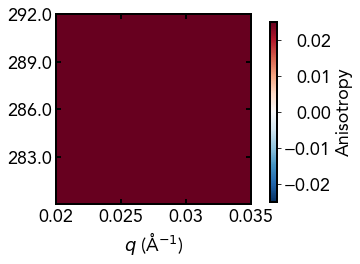

In [80]:
cmap = mpl.cm.RdBu_r
cmap.set_bad((246/255, 246/255, 246/255), 1)

start_q, end_q = 0.02, 0.035

[fig, axes] = setup_plot()

im_cbar = AR.sel(q = slice(start_q, end_q), energy = slice(start_en, end_en)).plot(
    x = 'q', y = 'energy',
    ax = axes,
    # vmin = -np.nanmax([abs(np.nanpercentile(AR, 10)), abs(np.nanpercentile(AR, 90))]),
    # vmax = np.nanmax([abs(np.nanpercentile(AR, 10)), abs(np.nanpercentile(AR, 90))]),
    vmin = -0.025,
    vmax = 0.025,
    cmap = cmap,
    add_colorbar = False)

cbar_ax = fig.add_axes([0.975, 0.135, 0.03, 0.715])
cbar = fig.colorbar(im_cbar, cax = cbar_ax)

plt.setp(cbar.ax.get_yticklabels(), ha = "right")
cbar.ax.tick_params(pad = 50)
# cbar.ax.set_ylabel('Anisotropy\n(Orientation)', rotation = 0)
cbar.ax.set_ylabel('Anisotropy')

# cbar.ax.yaxis.label.set_verticalalignment('center') # Adjust as needed: 'top', 'center', 'bottom'
# cbar.ax.yaxis.label.set_horizontalalignment('left') # Adjust as needed: 'left', 'center', 'right'

# axes.set_xlabel('$\it{q}$ (Å$^{-1}$)\n(Structure)', rotation = 0)
axes.set_xlabel('$\it{q}$ (Å$^{-1}$)')
# axes.set_xlabel('')

# axes.set_ylabel('Energy (eV)\n(Chemistry)', rotation = 0)  
# axes.set_ylabel('Energy (eV)')  
axes.set_ylabel('')  

# axes.yaxis.get_label().set_verticalalignment('center') # Adjust as 'top', 'center', 'bottom'
# axes.yaxis.label.set_horizontalalignment('right') # Adjust as needed: 'left', 'center', 'right'


axes.set_xlim([start_q, end_q])
axes.set_ylim([start_en, end_en])
x_ticks = generate_ticks(start_q, end_q, num_ticks = 4, rounding_order = 0.001)
y_ticks = generate_ticks(start_en, end_en, num_ticks = 5, rounding_order = 0.1)
axes.set_xticks(x_ticks)
axes.set_yticks(y_ticks)
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
x_ticks_strs = [str(value) for value in x_ticks]
# x_ticks_strs[0] = ''
# x_ticks_strs[-1] = ''
axes.set_xticklabels(x_ticks_strs)
# axes.set_xticklabels('')
y_ticks_strs = [str(value) for value in y_ticks]
y_ticks_strs[0] = ''
# y_ticks_strs[-1] = ''
axes.set_yticklabels(y_ticks_strs)
# axes.set_yticklabels('')

axes.xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', top = 'on')
axes.xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', top = 'on')
axes.yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
axes.yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')

save_fig(fig, -1, reduced_save_dir, 'AR', 300)

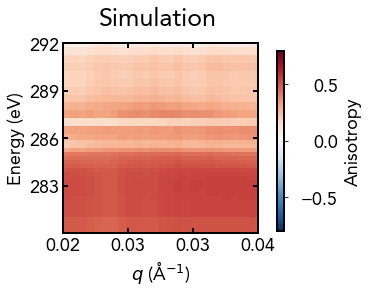

In [85]:
start_q = 0.02
end_q = 0.035

[fig, axes] = setup_plot()

im_cbar = AR.sel(energy = slice(start_en, end_en)).plot(
    x = 'q', y = 'energy',
    ax = axes,
    # vmin = -np.nanmax([abs(np.nanpercentile(AR, 10)), abs(np.nanpercentile(AR, 90))]),
    # vmax = np.nanmax([abs(np.nanpercentile(AR, 10)), abs(np.nanpercentile(AR, 90))]),
    vmin = -0.8,
    vmax = 0.8,
    cmap = 'RdBu_r',
    add_colorbar = False)

cbar_ax = fig.add_axes([0.975, 0.135, 0.03, 0.715])
cbar = fig.colorbar(im_cbar, cax = cbar_ax)

plt.setp(cbar.ax.get_yticklabels(), ha = "right")
cbar.ax.tick_params(pad = 50)

# cbar.ax.set_ylabel('Anisotropy\n(Orientation)', rotation = 0, labelpad=60)
cbar.ax.set_ylabel('Anisotropy', labelpad=15)

cbar.ax.yaxis.label.set_verticalalignment('center') # Adjust as needed: 'top', 'center', 'bottom'
cbar.ax.yaxis.label.set_horizontalalignment('center') # Adjust as needed: 'left', 'center', 'right'

# axes.set_xlabel('$\it{q}$ (Å$^{-1}$)\n(Structure)', rotation = 0)
axes.set_xlabel('$\it{q}$ (Å$^{-1}$)')
# axes.set_xlabel('')

# axes.set_ylabel('Energy (eV)\n(Chemistry)', rotation = 0, labelpad=10)  
axes.set_ylabel('Energy (eV)')  

# axes.yaxis.get_label().set_verticalalignment('center') # Adjust as 'top', 'center', 'bottom'
# axes.yaxis.label.set_horizontalalignment('right') # Adjust as needed: 'left', 'center', 'right'

fig.suptitle(f'Simulation', fontsize = 25, y = 1.025, x = 0.5)

axes.set_xlim([start_q, end_q])
axes.set_ylim([start_en, end_en])
x_ticks = generate_ticks(start_q, end_q, num_ticks = 4, rounding_order = 0.001)
y_ticks = generate_ticks(start_en, end_en, num_ticks = 5, rounding_order = 1)
axes.set_xticks(x_ticks)
axes.set_yticks(y_ticks)
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
x_ticks_strs = [str(value) for value in x_ticks]
# x_ticks_strs[0] = ''
# x_ticks_strs[-1] = ''
# axes.set_xticklabels(x_ticks_strs)
# axes.set_xticklabels('')
y_ticks_strs = [str(value) for value in y_ticks]
y_ticks_strs[0] = ''
# y_ticks_strs[-1] = ''
axes.set_yticklabels(y_ticks_strs)

axes.xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', top = 'on')
axes.xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', top = 'on')
axes.yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
axes.yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')

plt.show()

save_fig(fig, -1, reduced_save_dir, 'AR', 300)

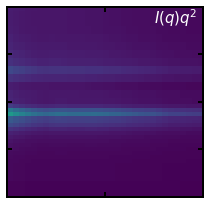

In [82]:
cmap = mpl.cm.viridis
cmap.set_bad((68/255, 1/255, 84/255), 1)

[fig, axes] = setup_plot()

im_cbar = Iq2.plot(
    x = 'q', y = 'energy',
    ax = axes,
    vmin = 0,
    vmax = np.nanpercentile(Iq2, 97.5),
    cmap = cmap,
    add_colorbar = False)

Iq2s.append(Iq2)

# cbar_ax = fig.add_axes([0.975, 0.145, 0.03, 0.715])
# fig.colorbar(im_cbar, cax = cbar_ax)

# fig.suptitle(f'{current_scan_pol0.sample_name}, {current_edge} edge', fontsize = 20, y = 1, x = 0.5)
axes.set_title('')
axes.text(0.975, 0.91, '$I(q) q^{2}$', color = 'white', fontsize = 15, transform = axes.transAxes, horizontalalignment = 'right')

# cbar.ax.yaxis.label.set_verticalalignment('center') # Adjust as needed: 'top', 'center', 'bottom'
# cbar.ax.yaxis.label.set_horizontalalignment('left') # Adjust as needed: 'left', 'center', 'right'

# axes.set_xlabel('$\it{q}$ (Å$^{-1}$)')
axes.set_xlabel('')

# axes.set_ylabel('Energy (eV)')  
axes.set_ylabel('')  

# axes.yaxis.get_label().set_verticalalignment('center') # Adjust as 'top', 'center', 'bottom'
# axes.yaxis.label.set_horizontalalignment('right') # Adjust as needed: 'left', 'center', 'right'


axes.set_xlim([start_q, end_q])
axes.set_ylim([start_en, end_en])
x_ticks = generate_ticks(start_q, end_q, num_ticks = 5, rounding_order = 0.01)
y_ticks = generate_ticks(start_en, end_en, num_ticks = 5, rounding_order = 1)
axes.set_xticks(x_ticks)
axes.set_yticks(y_ticks)
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
x_ticks_strs = [str(value) for value in x_ticks]
x_ticks_strs[0] = ''
# x_ticks_strs[-1] = ''
axes.set_xticklabels(x_ticks_strs)
axes.set_xticklabels('')
y_ticks_strs = [str(value) for value in y_ticks]
y_ticks_strs[0] = ''
# y_ticks_strs[-1] = ''
# axes.set_yticklabels(y_ticks_strs)
axes.set_yticklabels('')

axes.xaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', top = 'on')
axes.xaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', top = 'on')
axes.yaxis.set_tick_params(which = 'major', size = 5, width = 2, direction = 'in', right = 'on')
axes.yaxis.set_tick_params(which = 'minor', size = 2.5, width = 2, direction = 'in', right = 'on')

plt.show()

save_fig(fig, -1, reduced_save_dir, 'Iq2', 300)